In [95]:
import numpy as np
import xarray as xr
import os
import pathlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [15]:
base_path = f"{os.environ['HOME']}/lectures"

In [96]:
ds = xr.open_mfdataset(f"{base_path}/data/raw/pressure_level/1000hPa/temperature/*/*.nc", combine='by_coords', chunks={'time': 30})
ds['t'] = ds['t'] - 273.15 # Convert from Kelvin to Celsius
ds

<xarray.Dataset> Size: 406MB
Dimensions:    (time: 17544, latitude: 49, longitude: 59)
Coordinates:
  * longitude  (longitude) float32 236B -53.5 -53.25 -53.0 ... -39.25 -39.0
  * latitude   (latitude) float32 196B -13.75 -14.0 -14.25 ... -25.5 -25.75
  * time       (time) datetime64[ns] 140kB 2019-01-01 ... 2020-12-31T23:00:00
Data variables:
    t          (time, latitude, longitude) float64 406MB dask.array<chunksize=(24, 49, 59), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-09 17:17:10 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [65]:
lat = ds.latitude
lon = ds.longitude
west = lon.min().values
east = lon.max().values
south = lat.min().values
north = lat.max().values
lat2d, lon2d = xr.broadcast(lat, lon)

/home/adriano/lectures/.venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'min_value', 'max_value'
  result = super().contourf(*args, **kwargs)
/home/adriano/lectures/.venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'min_value', 'max_value'
  result = super().contourf(*args, **kwargs)


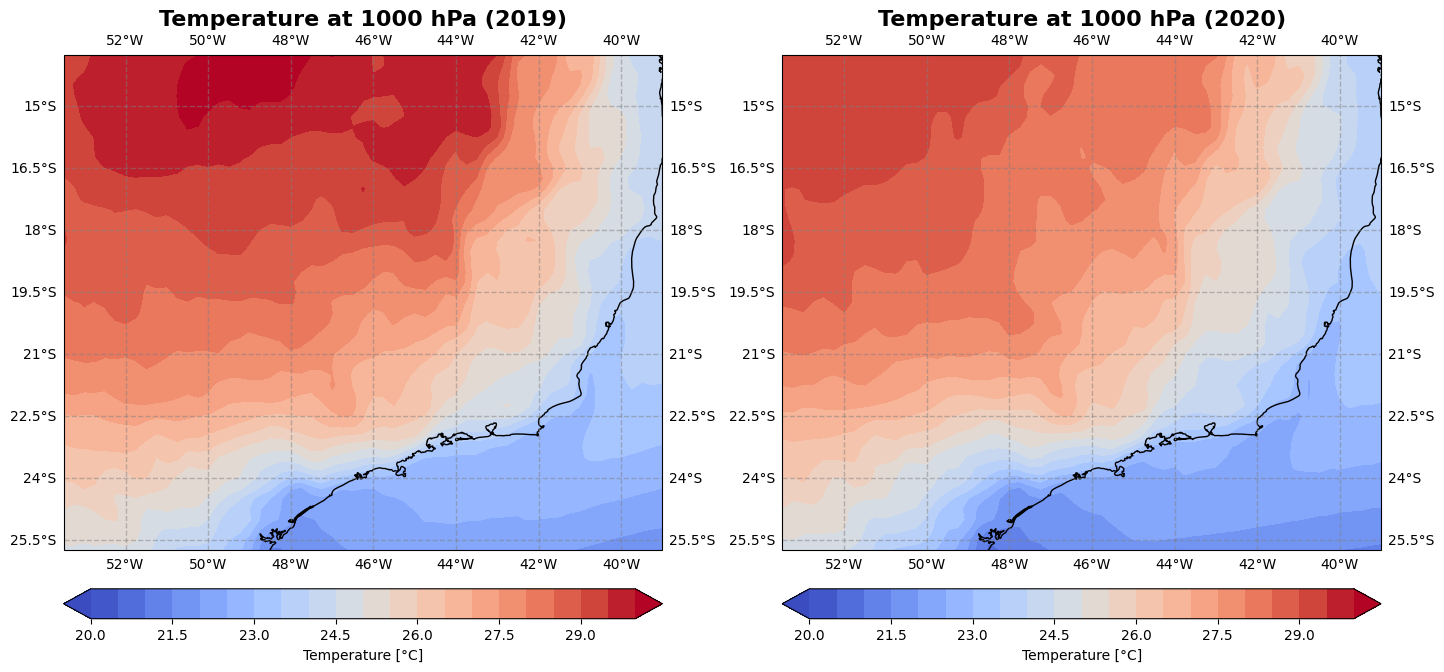

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(17, 10), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True)

years = [2019, 2020]
min_value = 20
max_value = 30
step = 0.5
levels = np.arange(min_value, max_value+step, step)
cbar_kwargs = {'orientation': 'horizontal', 'label': 'Temperature [°C]', 'pad': 0.05}

for i, _ in enumerate(ax):
    ax[i].set_title(f"Temperature at 1000 hPa ({years[i]})", fontsize=16, fontweight='bold')
    ax[i].set_extent([west, east, south, north], crs=ccrs.PlateCarree())
    ax[i].coastlines()
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    if i == 0:
        gl.ylabels_left = True
    else:
        gl.ylabels_right = True

    # select data according to year
    ds_year = ds.sel(time=str(years[i]))['t'].mean(dim='time')
    cs = ax[i].contourf(
        lon2d, 
        lat2d, 
        ds_year, 
        levels=levels, 
        min_value=min_value, 
        max_value=max_value,
        cmap='coolwarm', 
        transform=ccrs.PlateCarree(), extend='both'
    )
    fig.colorbar(cs, ax=ax[i], **cbar_kwargs)



In [114]:
# save 2019-traing and 2020-test data
out_path = f"{base_path}/data/processed/netcdf/temperature_1000hPa"
pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)

ds.sel(time='2019').to_netcdf(f"{out_path}/temperature_1000hPa_2019_train.nc")
ds.sel(time='2020').to_netcdf(f"{out_path}/temperature_1000hPa_2020_test.nc")